In [104]:
from misc import contour_maps, get_closest_gnid, gNID, get_gnid_consensus
from ib_color_naming.src.ib_naming_model import load_model
import pickle 
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS
from sklearn.preprocessing import OneHotEncoder
from ib_color_naming.src.figures import mode_map
from correlation_clustering import compute_consensus_map, max_correlation
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from copy import deepcopy
import os
ib_model = load_model()
need = ib_model.pM.flatten()
PRECISION = 1e-16
def mode_filter(data):
    y = data.argmax(axis=1)
    modemap = np.zeros_like(data)
    modemap[np.arange(y.size), y] = 1
    major = np.sum(modemap, axis=0) >= 10
    data = data[:, major] + 1e-20
    data = data / np.sum(data, axis=1).reshape(330,1)

    
    return data
def marginal(pXY, axis=1):
    return pXY.sum(axis)


def conditional(pXY):
    pX = pXY.sum(axis=1, keepdims=True)
    return np.where(pX > PRECISION, pXY / pX, 1 / pXY.shape[1])

def xlogx(v):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(v > PRECISION, v * np.log2(v), 0)


def entropy(p, axis=None):
    return -xlogx(p).sum(axis=axis)


def mutual_information(pXY):
    return entropy(pXY.sum(axis=0)) + entropy(pXY.sum(axis=1)) - entropy(pXY)

def kl(p, q):
    return (xlogx(p) - np.where(p > PRECISION, p * np.log2(q + PRECISION), 0)).sum()



def IB_accuracy(pMW, pU_M):
    pWU = pMW.T @ pU_M
    return mutual_information(pWU)

def IB(beta, sender, prior, p, max_iter=1000):
    from scipy.special import softmax
    iteration = 0
    diff = 100000
    eps = 1e-2
    while diff > eps and iteration < max_iter:
        old = deepcopy(sender)
        p_w = np.sum(prior * sender + PRECISION, axis=0, keepdims=True).flatten()
        print(p_w.shape)
        listener = sender * prior / p_w
        # compute m_hat
        m_hat = listener.T @ p
        for m in range(sender.shape[0]):
            z = [np.log(p_w[v] + PRECISION) -beta * kl(p[m, :], m_hat[v, :]) for v in range(sender.shape[1])]
            sender[m, :] = softmax(z)


        iteration += 1
        diff = np.mean(np.abs(sender - old))

    acc = IB_accuracy(sender * prior, p)
    comp = mutual_information(sender * prior)

    return sender, acc, comp


2024-03-14 10:43:35,062 [INFO] [ib_naming_model - load_model] loading model from file: ./models/IB_color_naming_model/model.pkl


In [2]:
with open('iterated_learning_exp_cogsci/NIL/encoders.pkl', 'rb') as f:
    nil_encoders = pickle.load(f)
#nil_consensus = get_gnid_consensus(nil_encoders, need)
#with open('iterated_learning_exp_cogsci/IL/encoders.pkl', 'rb') as f:
#    encoders = pickle.load(f)
#il_consensus = get_gnid_consensus(encoders, need)
with open('data/wcs_encoders.pkl', 'rb') as f:
    wcs_encoders = pickle.load(f)
with open('iterated_learning_exp_cogsci/RL/encoders.pkl', 'rb') as f:
    rl_encoders = pickle.load(f)
#rl_consensus = get_gnid_consensus(encoders, need)
with open('iterated_learning_exp_cogsci/random_model/encoders.pkl', 'rb') as f:
    rm_encoders = pickle.load(f)


In [40]:
# find the nil furtheset away from wcs
nil2wcs = [get_closest_gnid(encoder, wcs_encoders, need=need) for encoder in nil_encoders]
# get arg largest
nil2wcs = np.array(nil2wcs)
nil2wcs = np.argsort(nil2wcs)[::-1]
# Get furthest away from wcs based on vocab size
furthest_away = {}
closest_wcs = {}
gnid_values = {}
for i in nil2wcs:
    vocab_size = len(np.unique(nil_encoders[i].argmax(axis=1)))
    if vocab_size not in furthest_away:
        furthest_away[vocab_size] = i
        gnid, wcs_idx = get_closest_gnid(nil_encoders[i], wcs_encoders, need=need, return_index=True)
        closest_wcs[vocab_size] = wcs_idx
        gnid_values[vocab_size] = gnid



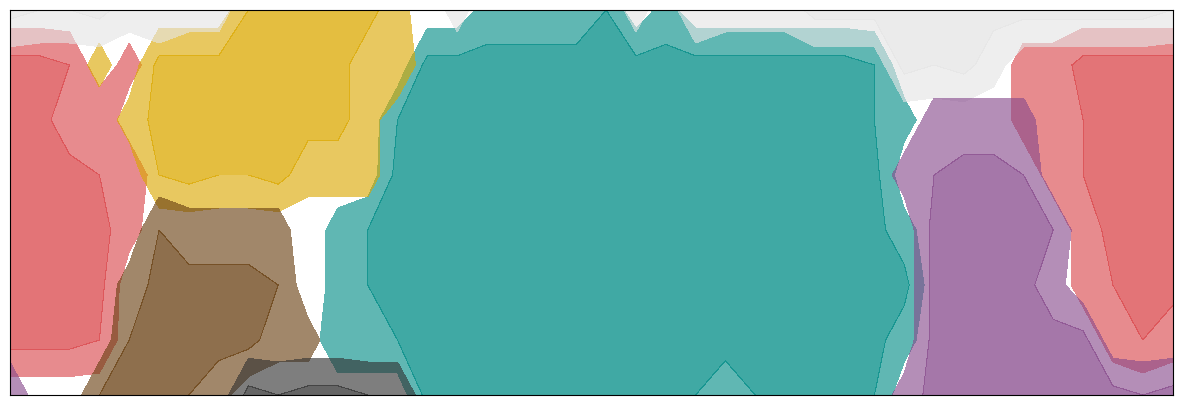

In [43]:
plt.rcParams["figure.figsize"] = (15, 5)
os.makedirs('outlier_figs/', exist_ok=True)
for i in range(3, 8):
    plt.close()
    contour_maps(nil_encoders[furthest_away[i]], ib_model, plot_modemap=False)
    plt.savefig(f'outlier_figs/nil_{i}_gnid_{gnid_values[i]}.pdf')
    plt.close()
    contour_maps(wcs_encoders[closest_wcs[i]], ib_model, plot_modemap=False)
    plt.savefig(f'outlier_figs/wcs_{i}_wcs_idx_{closest_wcs[i]}.pdf')
    

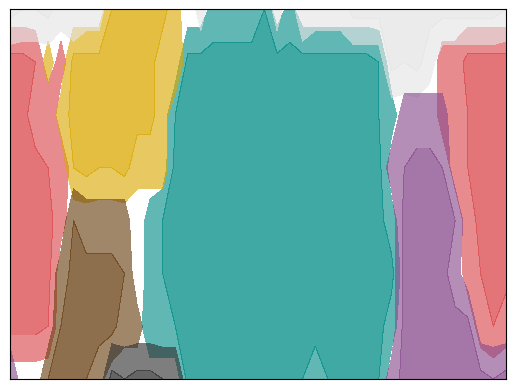

In [36]:
contour_maps(wcs_encoders[closest_wcs[7]], ib_model, plot_modemap=False)

In [94]:
with open('data/wcs_encoders.pkl', 'rb') as f:
    wcs_encoders = pickle.load(f)
#wcs_encoders = [mode_filter(e) for e in wcs_encoders]

0.19377303868076434

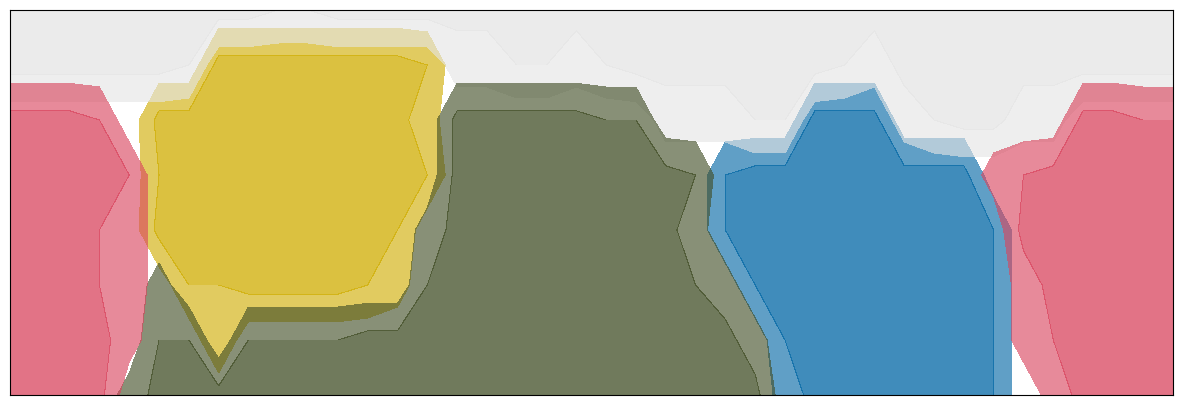

In [158]:
plt.rcParams["figure.figsize"] = (15, 5)
n_words = 5
contour_maps(nil_consensus[n_words], ib_model, plot_modemap=False)
#mode_map(nil_consensus[n_words], small_grid=False)
gnid, idx = get_closest_gnid(nil_consensus[n_words], wcs_encoders, need=ib_model.pM.flatten(), return_index=True)
gnid

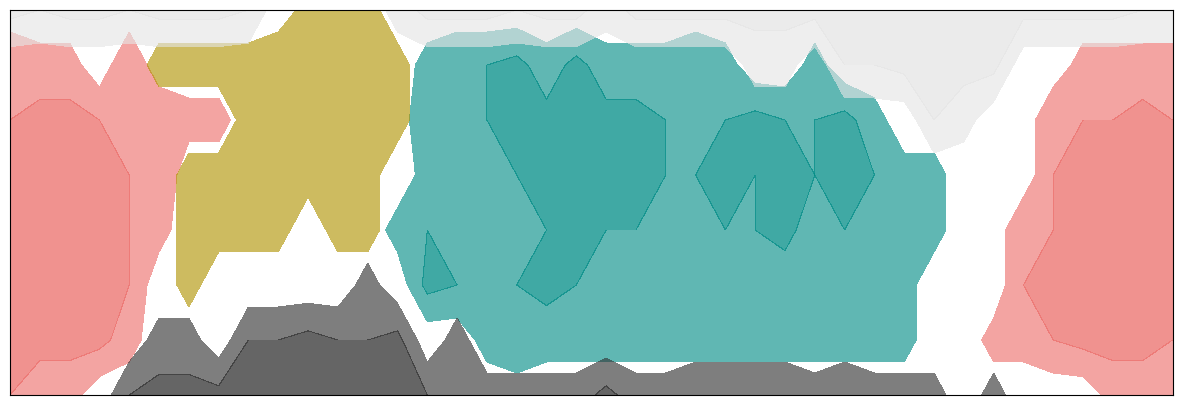

In [159]:
contour_maps(wcs_consensus[n_words], ib_model, plot_modemap=False)
#contour_maps(wcs_encoders[idx], ib_model, plot_modemap=False)


-6.658843264549535e-14


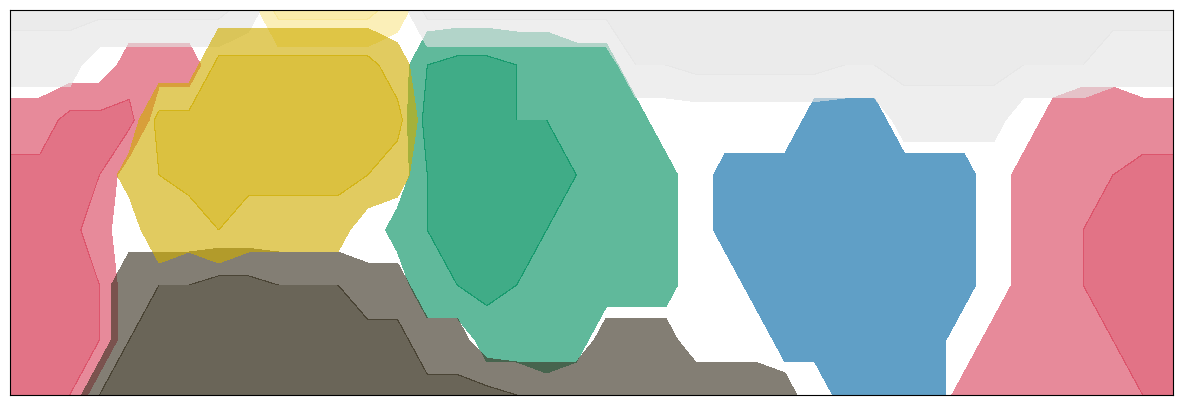

In [162]:
_, _, beta, q_fit = ib_model.fit(wcs_consensus[n_words])
#q_fit, _ ,_ = IB(beta, wcs_consensus[n_words], prior=ib_model.pM, p=ib_model.pU_M)
contour_maps(q_fit, ib_model, plot_modemap=False)
eps, _, _, _ = ib_model.fit(q_fit)
print(eps)

In [130]:
v5encoders = []
v5comp = []
for e in nil_encoders:
    argmax = np.argmax(e, axis=1)
    unique = len(np.unique(argmax))
    if unique == 3:
        v5encoders.append(e)
spkr_sim = np.zeros((len(v5encoders), len(v5encoders)))
spkr_dst = np.zeros((len(v5encoders), len(v5encoders)))
for i, e1 in enumerate(v5encoders):
    for j, e2 in enumerate(v5encoders):
        spkr_sim[i, j] = 1 - gNID(e1, e2, ib_model.pM)
        spkr_dst[i, j] = gNID(e1, e2, ib_model.pM)

In [131]:
# spectral clustering
n_clusters = 2
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, assign_labels='kmeans', n_neighbors=10, random_state=0)
labels = sc.fit_predict(spkr_sim)
clustering = {i: [] for i in np.unique(labels)}
#cores = {i: [] for i in np.unique(labels)}
#core_samples = sc.core_sample_indices_
for i, e in enumerate(v5encoders):
    clustering[labels[i]].append(e)
#    if i in core_samples:
##        cores[labels[i]].append(e)

# size of clusters
for k, v in clustering.items():
    print(k, len(v))

print(silhouette_score(spkr_dst, labels, metric='precomputed'))
#print(sc.core_sample_indices_)


0 84
1 18
0.35630202951724854


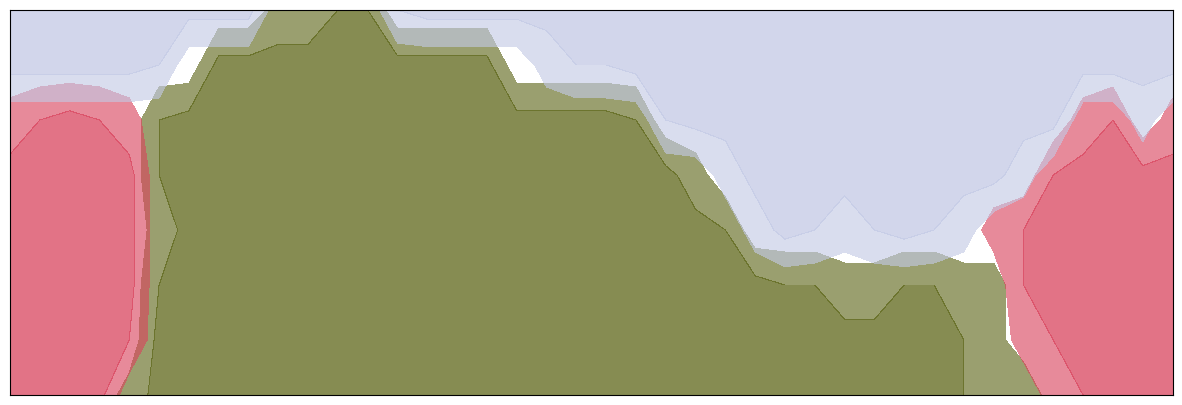

In [129]:
plt.rcParams["figure.figsize"] = (15, 5)
gnid_consensus1 = get_gnid_consensus(clustering[0], need, avg_centroid=False)
contour_maps(gnid_consensus1[3], ib_model, plot_modemap=False)


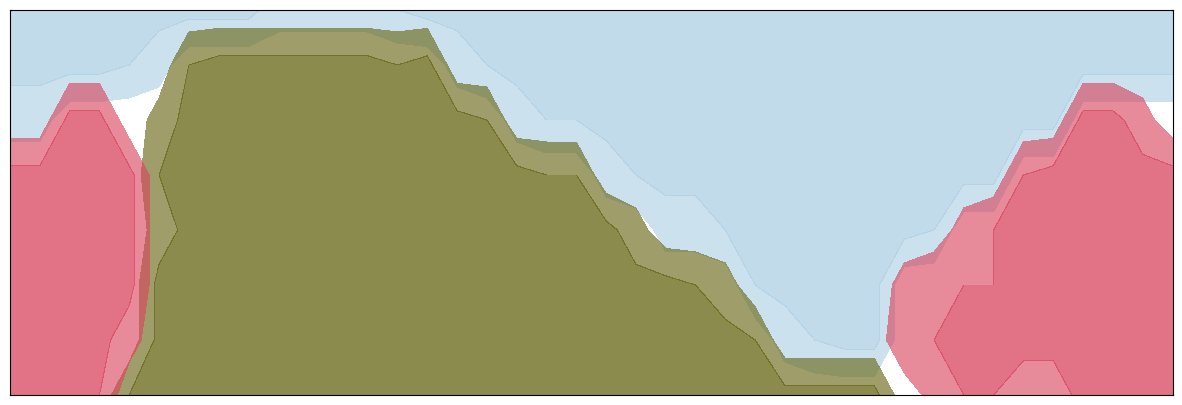

In [30]:
gnid_consensus2 = get_gnid_consensus(clustering[1], need)
contour_maps(gnid_consensus2[3], ib_model, plot_modemap=False)

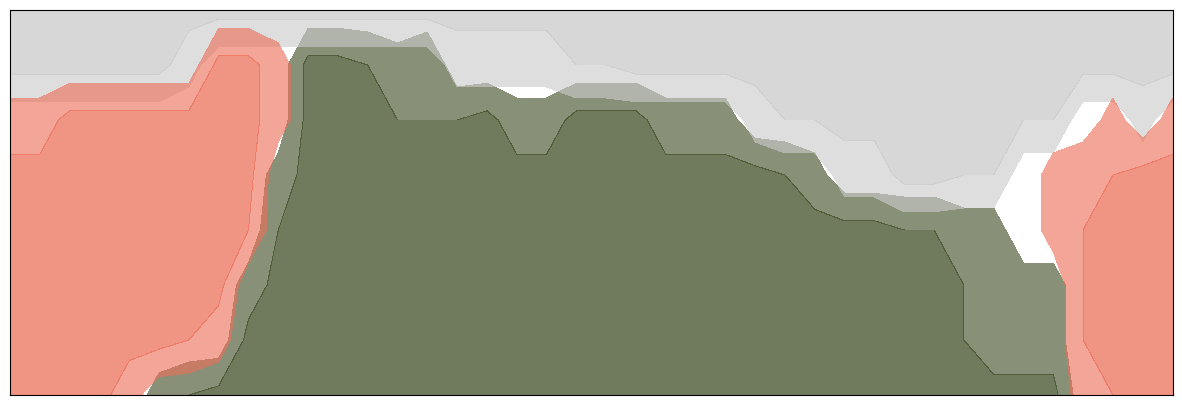

In [27]:
gnid_consensus3 = get_gnid_consensus(clustering[3], need)
contour_maps(gnid_consensus3[3], ib_model, plot_modemap=False)

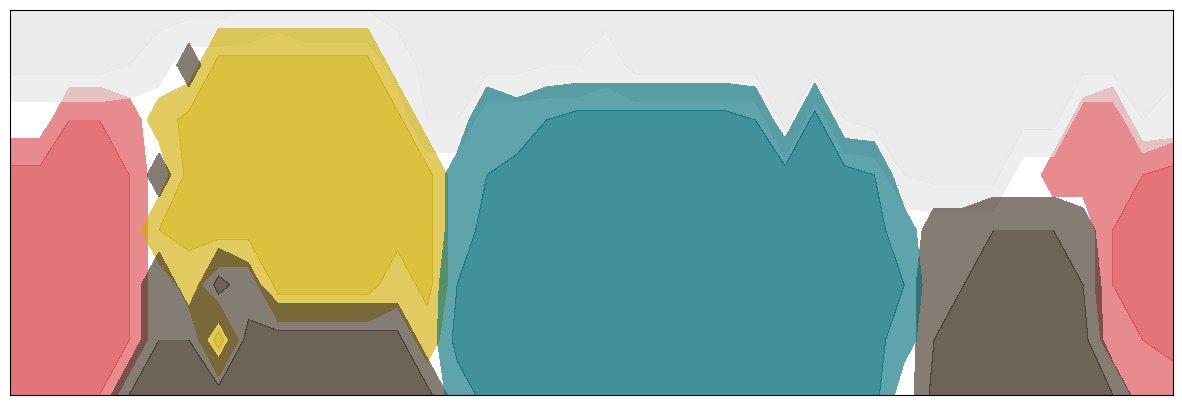

In [111]:
disim_matrix = []
# for each nil encoder find the
for e1 in nil_encoders:
    disim_matrix.append([1 - gNID(e1, e2, ib_model.pM) for e2 in nil_encoders])


In [112]:
disim_matrix = np.array(disim_matrix)


In [159]:
# spectral clustering
sc = SpectralClustering(n_clusters=6, affinity='precomputed', n_init=100, assign_labels='discretize')
sc.fit(disim_matrix)
sc.labels_
clusters = {}
for i, e in enumerate(encoders):
    if sc.labels_[i] not in clusters:
        clusters[sc.labels_[i]] = []
    clusters[sc.labels_[i]].append(e)

[0 0 2 2 0 0 1 2 2 1 1 1 1 1 0 0 2 1 0 1 2 0 2 1 1 1 0 2 0 2 0 0 1 0 2 1 0
 2 1 0 2 1 1 0 1 0 1 1 0 2 1 0 2 1 0 0 1 1 0 1 2 0 0 0 2 0 0 2 1 0 2 1 2 0
 1 2 0 0 1 1 1 0 0 0 1 0 1 2 1 1 1 0 1 1 0 1 2 2 0 0 2 0 1 0 2 0 0 0 0 1 1
 2 1 1 2 0 2 0 0 0 2 1 1 1 2 0 1 1 0 1 2 2 1 2 2 0 1 0 0 1 0 0 1 2 0 1 0 2
 0 2 0 0 0 1 1 1 2 0 0 0 0 2 1 0 1 1 0 1 0 1 1 0 2 1 0 2 0 1 2 1 1 2 1 2 2
 0 2 0 0 0 1 0 1 2 1 0 0 1 0 0 0 1 2 2 2 0 2 1 1 2 0 2 0 1 0 1 0 1 0 0 0 2
 1 0 1 1 1 1 0 0 2 1 0 1 0 1 0 0 0 2 0 0 2 0 2 0 0 1 1 2 0 0 0 0 1 2 1 1 2
 0 2 0 0 0 1 2 2 0 2 2 1 0 0 0 1 2 1 2 2 1 1 1 2 0 0 0 1 2 0 0 0 0 0 0 1 2
 1 2 1 0 1 0 0 1 2 1 0 0 1 0 1 1 2 0 1 1 2 2 0 1 2 0 1 0 2 1 0 1 2 0]


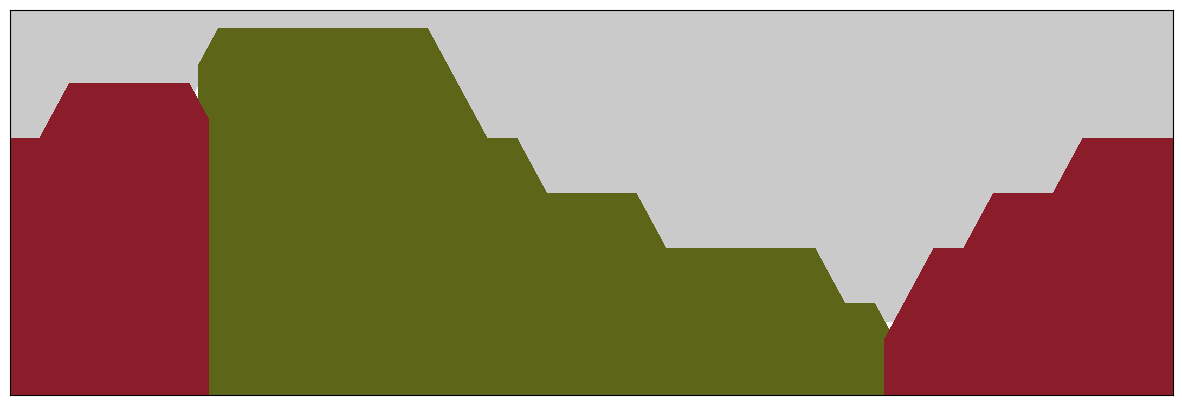

In [162]:
c = 0
words = [len(np.unique(e.argmax(axis=1))) for e in clusters[c]]
n_words = int(np.median(words))
cons_map = compute_consensus_map(clusters[c], n_words, 5)
print(cons_map)
cons_map = OneHotEncoder().fit_transform(cons_map.reshape(-1, 1)).toarray()
contour_maps(cons_map, ib_model, plot_modemap=True)

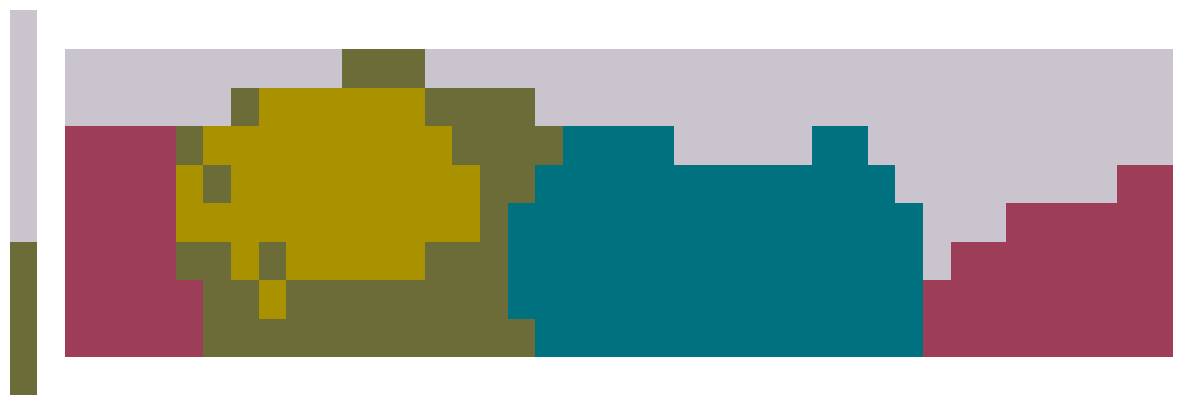

In [107]:
mode_map(nil_encoders[80], small_grid=False)

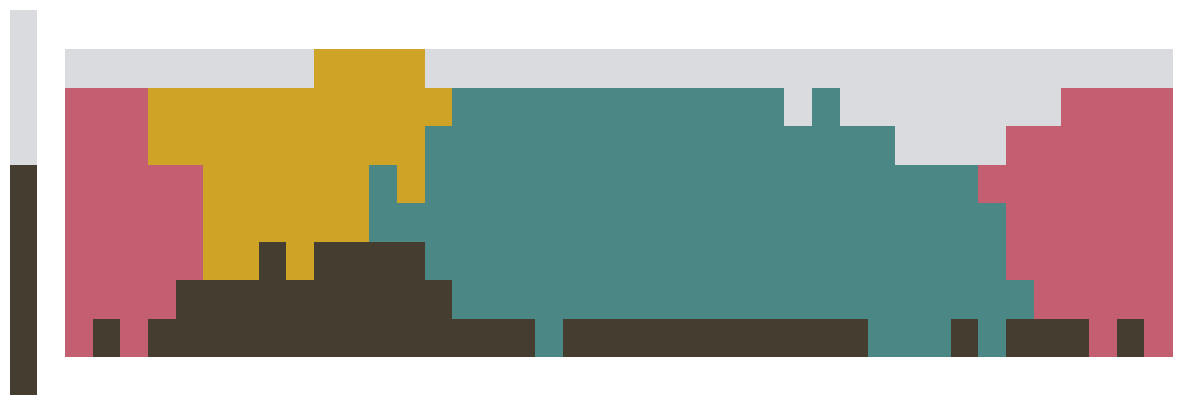

In [100]:
mode_map(wcs_encoders[idx], small_grid=False)

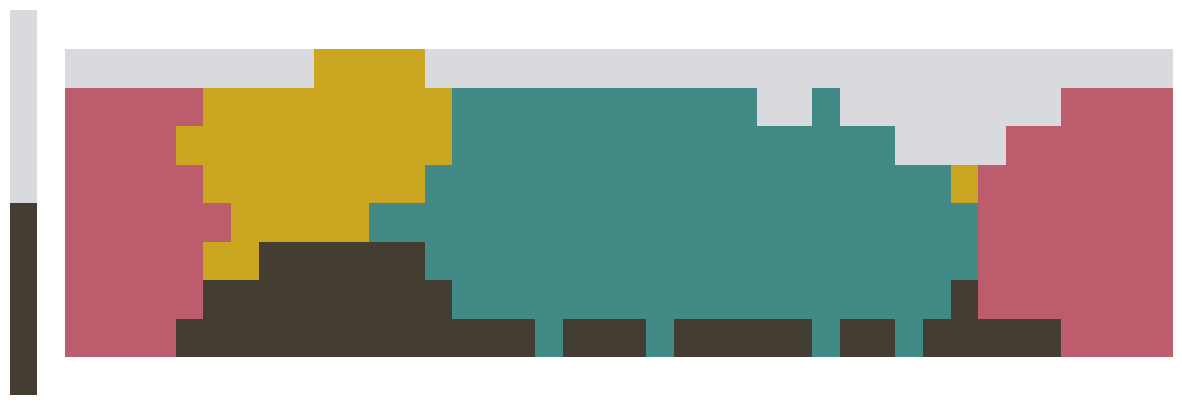

In [289]:
plt.rcParams["figure.figsize"] = (15, 5)
#contour_maps(wcs_consensus[4], ib_model, plot_modemap=True)
mode_map(wcs_consensus[5], small_grid=False)

In [164]:
c1 = []
c2 = []
c3 = []
c4 = []
complexities = []
for e in nil_encoders:
    comp = ib_model.complexity(e)
    complexities.append(comp)

In [165]:
# perform kmeans with k=4 on complexities
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(complexities).reshape(-1,1))
centr = kmeans.cluster_centers_
labels = kmeans.labels_

/Users/caremil/anaconda3/envs/p3-9/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [202]:
c_enc = []
for c in centr:
    # find the encoder closest to the centroid
    dists = []
    for e in encoders:
        dists.append(abs(ib_model.complexity(e) - c))
    c_enc.append(encoders[np.argmin(dists)])
clusters = {}
# sort into clusters based on number of mode terms
for i, e in enumerate(encoders):
    argmax = np.argmax(e, axis=1)
    unique = len(np.unique(argmax))
    unique = e.shape[1]
    if unique not in clusters:
        clusters[unique] = []
    clusters[unique].append(e)
    



In [213]:
def spectral_weight(i, j, encoder):
    if i == j:
        return 1
    else:
        return (encoder[i] * encoder[j]).sum()

In [214]:
n_words = 3
# compute similarity graph
graph = np.zeros((330, 330))
for encoder in nil_encoders:
    for i in range(330):
        for j in range(0, i):
            graph[i, j] += spectral_weight(i, j, encoder)
            graph[j, i] = graph[i, j]
graph = graph / len(nil_encoders)


In [249]:
n_words = 3
# compute similarity graph
wcs_graph = np.zeros((330, 330))
for encoder in wcs_encoders:
    for i in range(330):
        for j in range(0, i):
            wcs_graph[i, j] += spectral_weight(i, j, encoder)
            wcs_graph[j, i] = wcs_graph[i, j]
wcs_graph = wcs_graph / len(wcs_encoders)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


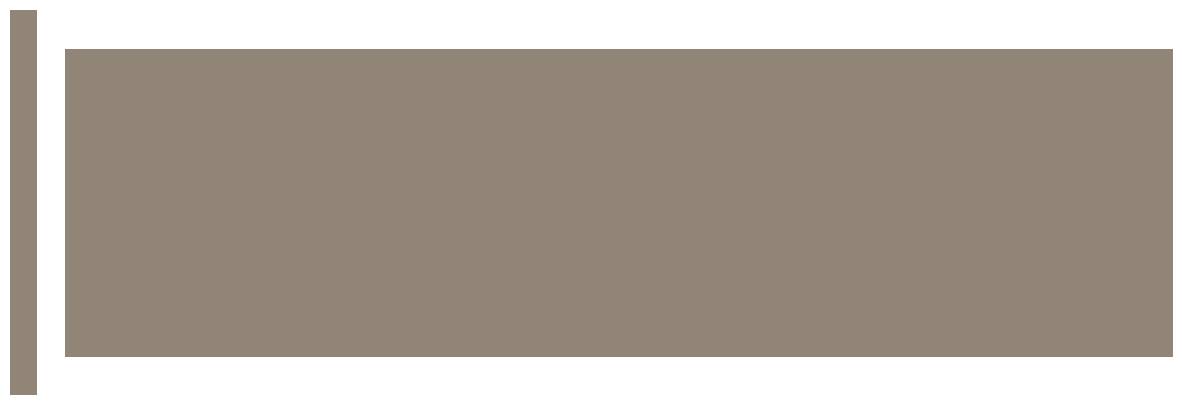

In [295]:
sc = SpectralClustering(n_clusters=5, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(wcs_graph)
#spectral_spkr = OneHotEncoder().fit_transform(sc.labels_.reshape(-1, 1)).toarray()
spectral_spkr, _ = max_correlation(wcs_graph * len(wcs_encoders), 5, 5)
print(spectral_spkr)
OneHotEncoder().fit_transform(spectral_spkr.reshape(-1, 1)).toarray()
mode_map(spectral_spkr, small_grid=False)
#contour_maps(spectral_spkr, ib_model, major_terms=True, plot_modemap=True)

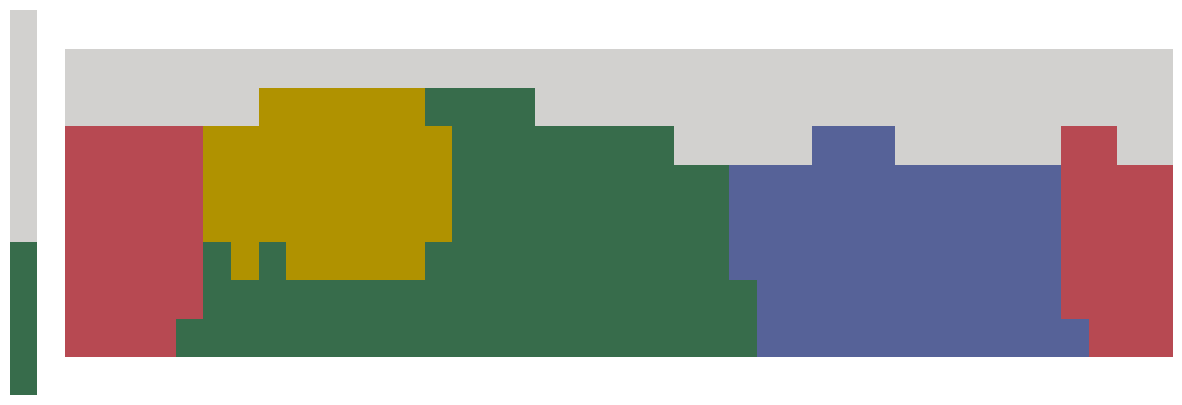

In [287]:
sc = SpectralClustering(n_clusters=5, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(graph)
spectral_spkr = OneHotEncoder().fit_transform(sc.labels_.reshape(-1, 1)).toarray()
mode_map(spectral_spkr, small_grid=False)
#contour_maps(spectral_spkr, ib_model, major_terms=True, plot_modemap=True)

In [271]:
v5encoders = []
for e in nil_encoders:
    argmax = np.argmax(e, axis=1)
    unique = len(np.unique(argmax))
    if unique == 5:
        v5encoders.append(e)
print(len(v5encoders))
spkr_sim = np.zeros((len(v5encoders), len(v5encoders)))
for i, e1 in enumerate(v5encoders):
    for j, e2 in enumerate(v5encoders):
        spkr_sim[i, j] = 1 - gNID(e1, e2, ib_model.pM)


360


In [273]:
# cluster into two sets 
sc = SpectralClustering(n_clusters=2, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(spkr_sim)
labels = sc.labels_
v5graph1 = np.zeros((330, 330))
v5graph2 = np.zeros((330, 330))
for k, e in enumerate(v5encoders):
    for i in range(330):
        for j in range(0, i):
            if labels[k] == 0 :
                v5graph1[i, j] += spectral_weight(i, j, e)
                v5graph1[j, i] = v5graph1[i, j]
            else:
                v5graph2[i, j] += spectral_weight(i, j, e)
                v5graph2[j, i] = v5graph2[i, j]


In [ ]:
# normalize


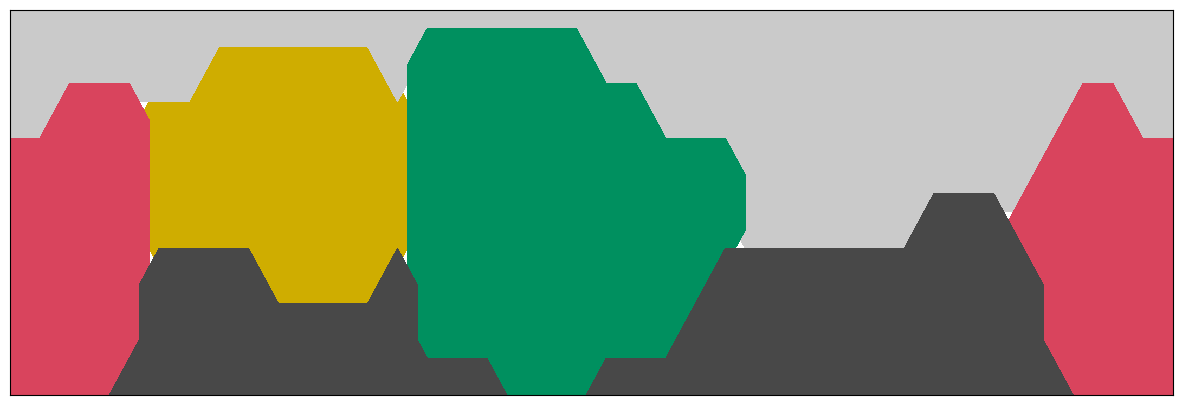

In [288]:
sc = SpectralClustering(n_clusters=5, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(v5graph2 / len(v5encoders))
spectral_spkr = OneHotEncoder().fit_transform(sc.labels_.reshape(-1, 1)).toarray()
#mode_map(spectral_spkr, small_grid=False)
contour_maps(spectral_spkr, ib_model, major_terms=True, plot_modemap=True)

[0 0 1 2 0 1 0 1 1 0 0 1 0 0 2 2 1 2 0 0 1 1 0 2 0 0 2 1 0 1 0 1 0 0 1 0 0
 1 0 0 1 1 0 2 0 2 0 1 0 2 2 2 1 0 0 1 0 1 2 0 1 0 1 0 1 2 0 1 0 2 1 0 1 2
 0 1 0 2 2 0 0 0 2 1 0 1 2 1 2 0 1 2 0 2 2 1 0 1 2 0 1 2 0 0 1 1 2 2 0 1 0
 1 2 0 1 2 2 1 0 2 1 0 0 1 1 1 0 1 2 2 1 1 0 2 1 0 0 0 2 0 2 2 0 0 0 1 0 1
 0 0 1 1 0 2 2 0 2 2 1 1 0 1 0 0 0 0 2 0 0 0 0 2 1 1 0 1 1 0 1 0 1 1 2 0 1
 0 1 0 2 1 0 0 1 1 0 0 1 2 2 0 1 0 1 2 0 2 1 1 0 1 0 1 2 1 1 0 1 0 2 0 2 0
 0 2 0 0 2 0 0 2 1 2 0 0 0 0 1 0 1 1 2 1 1 2 1 0 0 0 0 0 0 2 0 0 2 1 0 1 1
 2 1 2 2 0 0 1 1 0 1 1 0 2 1 2 1 1 0 1 0 0 0 0 2 2 1 2 1 1 0 2 0 1 2 2 2 0
 1 1 0 2 0 2 2 0 1 0 0 1 2 0 0 2 0 2 0 0 1 1 2 0 1 0 0 2 1 1 2 0 1 2]


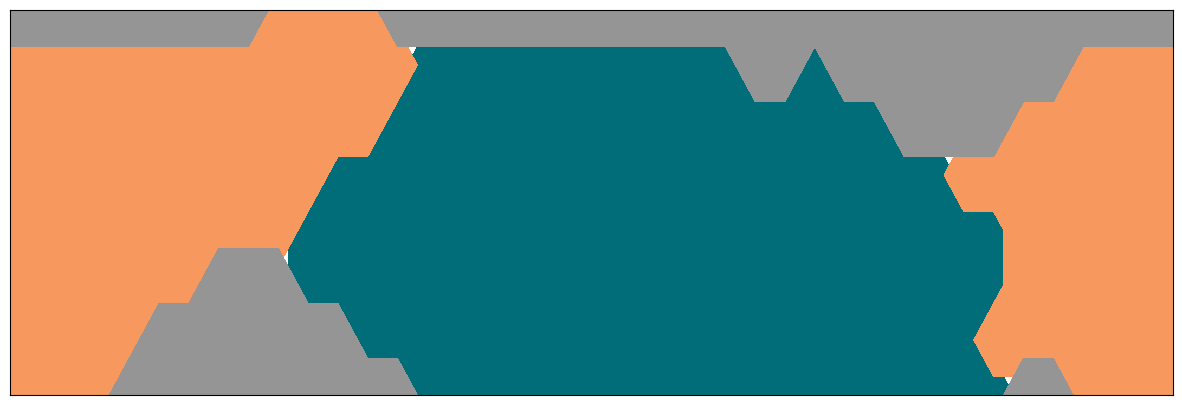

In [211]:
cons_map1 = compute_consensus_map(wcs_encoders, 3, 10)
print(cons_map1)
oh_cons1 = OneHotEncoder().fit_transform(cons_map1.reshape(-1,1)).toarray()

plt.rcParams["figure.figsize"] = (15, 5)
#mode_map(oh_cons1, small_grid=False)
contour_maps(oh_cons1, ib_model, major_terms=True, plot_modemap=True)


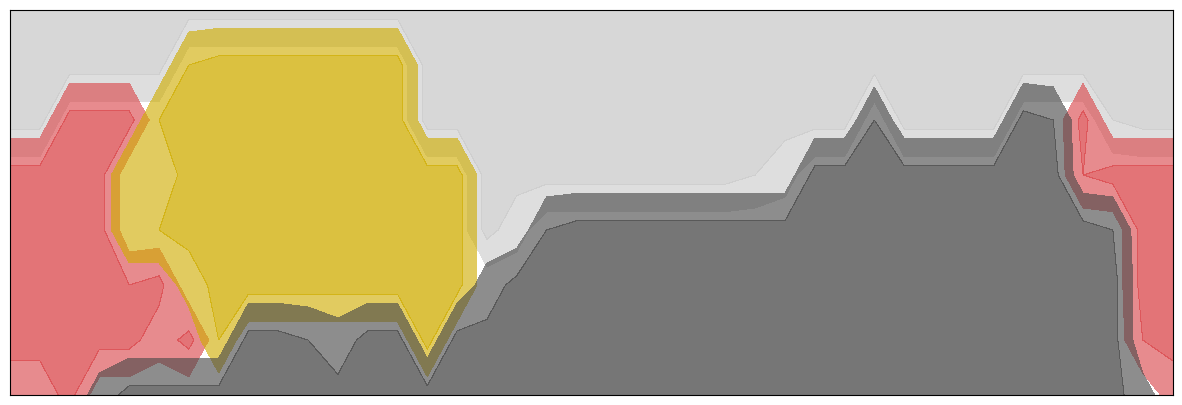

In [201]:
contour_maps(clusters[4][2], ib_model, major_terms=False, plot_modemap=False)

6
3
4
5
7
8


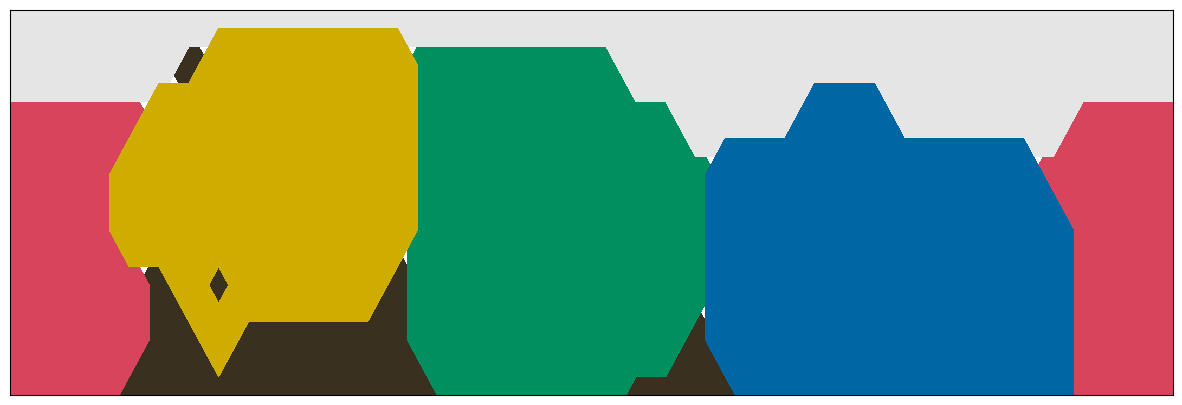

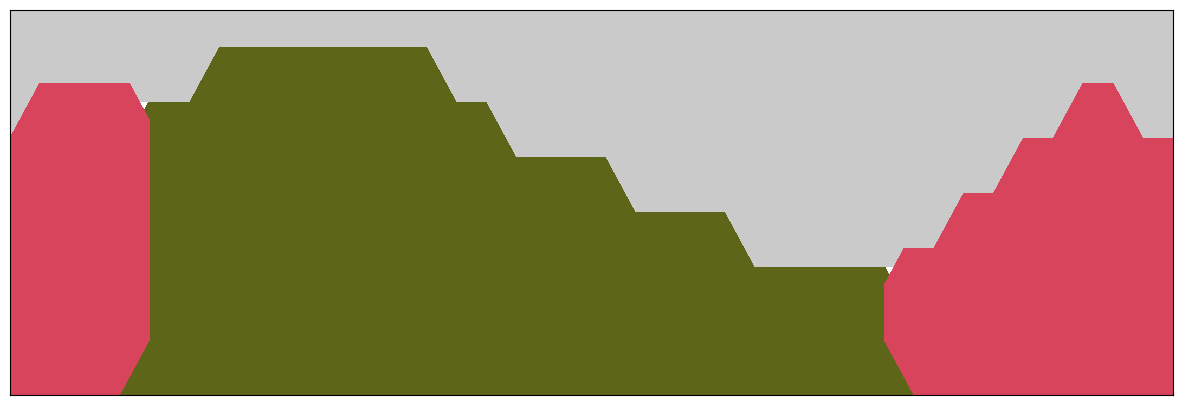

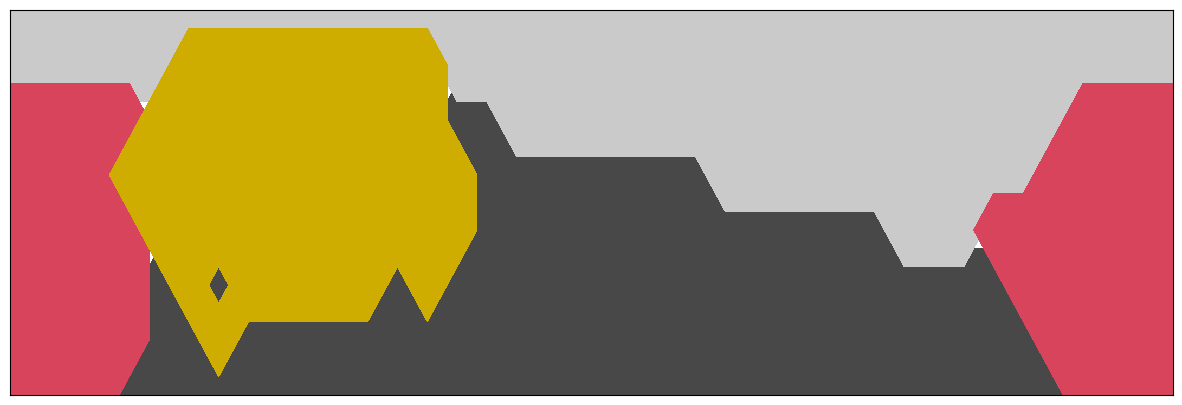

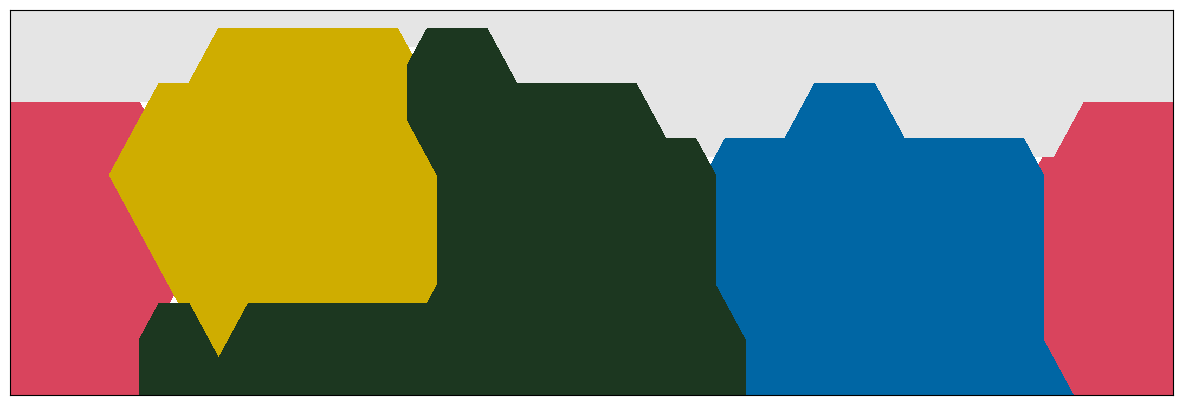

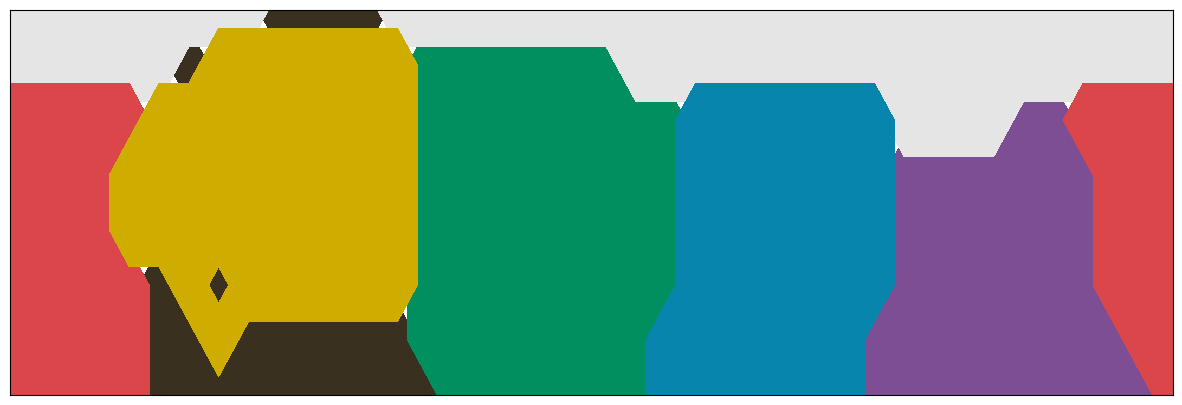

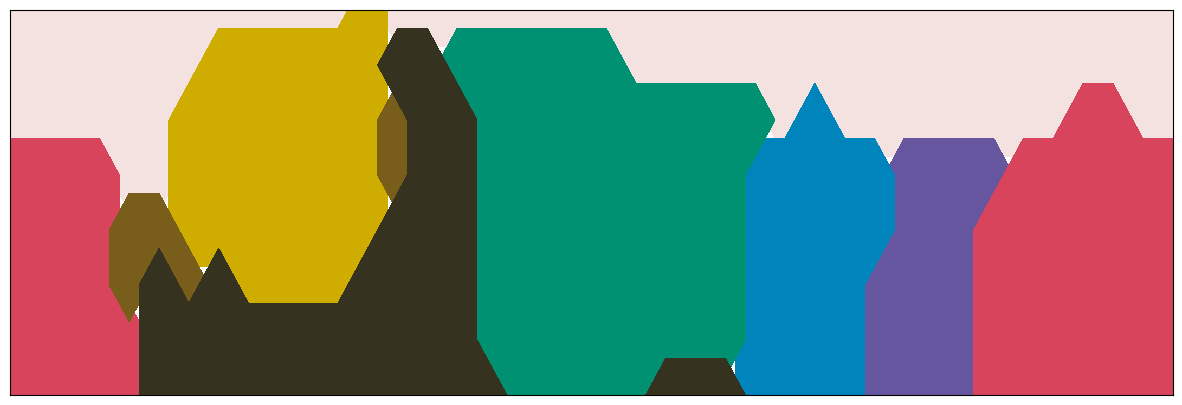

In [13]:
# one-hot encode the consensus map
for i in clusters.keys():
    print(i)
    # new figure
    plt.figure()
    cons_map1 = compute_consensus_map(clusters[i], i, 5)
    oh_cons1 = OneHotEncoder().fit_transform(cons_map1.reshape(-1,1)).toarray()
    plt.rcParams["figure.figsize"] = (15, 5)
    #mode_map(oh_cons1, small_grid=False)
    contour_maps(oh_cons1, ib_model, plot_modemap=True)

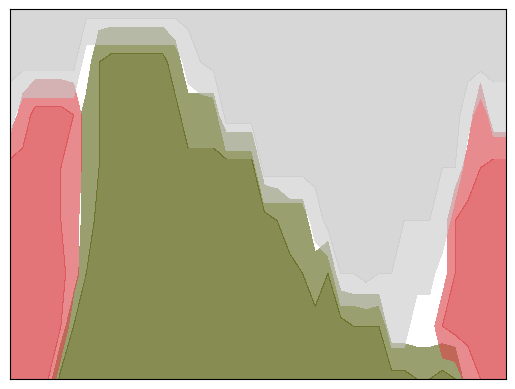

In [101]:
contour_maps(c_enc[0], ib_model)

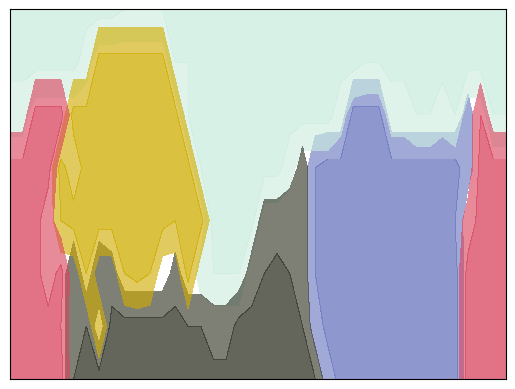

In [102]:
contour_maps(c_enc[1], ib_model)

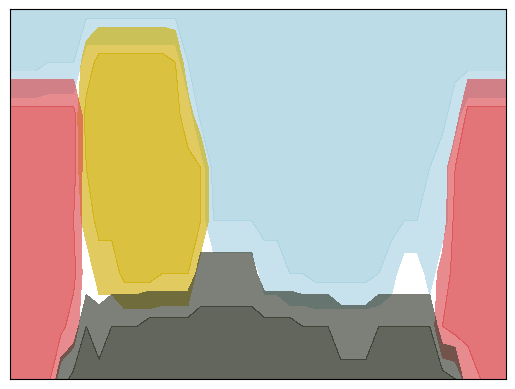

In [103]:
contour_maps(c_enc[2], ib_model)

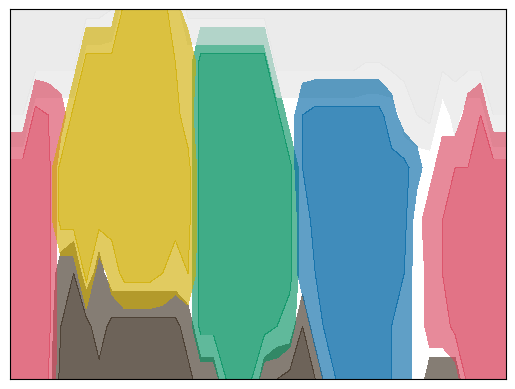

In [104]:
contour_maps(c_enc[3], ib_model)

In [105]:
contour_maps(c_enc[4], ib_model)

IndexError: list index out of range

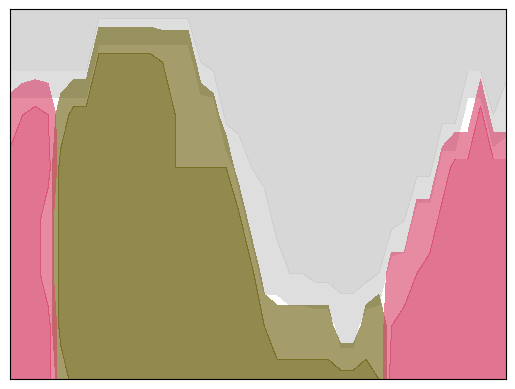

In [28]:

contour_maps(e1, ib_model)

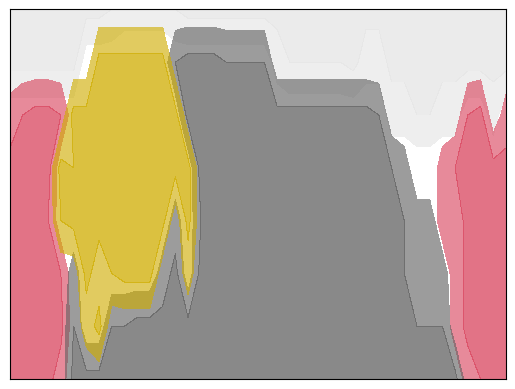

In [34]:
e2 = np.random.choice(len(c2))
e2 = c2[e2]
contour_maps(e2, ib_model)

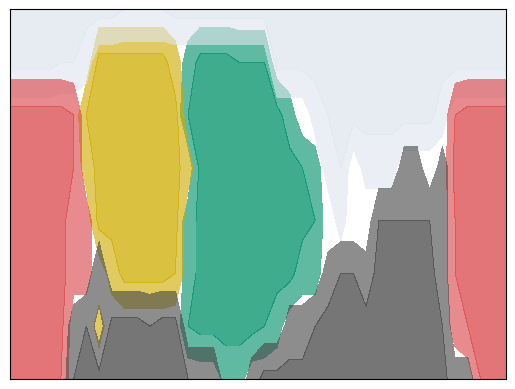

In [37]:
e3 = np.random.choice(len(c3))
e3 = c3[e3]
contour_maps(e3, ib_model)

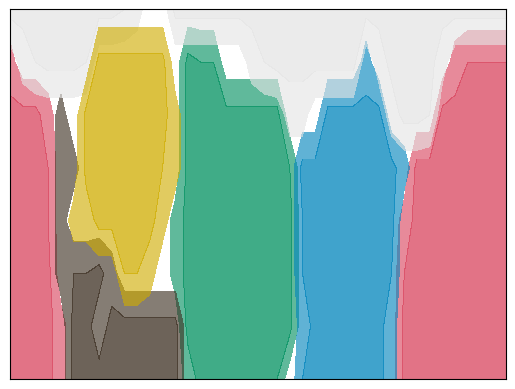

In [39]:
e4 = np.random.choice(len(c4))
e4 = c4[e4]
contour_maps(e4, ib_model)